In [191]:
# import packages
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import memory_profiler
import networkx as nx
import numpy as np
import openTSNE
import os
import pandas as pd
import plotly.express as px
import scipy.io
import scipy as sp
import seaborn
import sklearn 
import sklearn.neighbors 
import time

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.callbacks import Callback
from openTSNE.affinity import Affinities
from pathlib import Path
from sklearn.manifold import MDS, SpectralEmbedding, spectral_embedding
from sklearn.neighbors import NearestNeighbors

Graph Data:\
can_96 and dwt_1005 - Two structural datasets containing 96 nodes and 768 edges,
and 1005 nodes and 8621 edges, respectively. Both are obtained from the SuiteSparse
Matrix Collection (formerly: Florida Sparse Matrix Collection), \
publicly available on https://sparse.tamu.edu/ (Davis and Hu 2011).\
For dwt_1005 c.f. https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/dwt/dwt_1005.html.

In [136]:
# load graph data
dwt = sp.sparse.load_npz('./graph_data/dwt_1005.npz')
can = sp.sparse.load_npz('./graph_data/can_96.npz')

# Preprocess Graph Data
convert adjacency matrix to normalized affinity matrix

In [137]:
 def preprocessA(file_name):
    """
      Preprocesses adjacency matrix by normalizing it by row, symmetrizing it and normalizing it again to obtain affinities.
      
    input:
      file_name (str) without file format (.npz)
    
    returns preprocessed adjacency matrix (normalized by row, symmetrized, normalized) and its sum (==1)
    """
    matrix = sp.sparse.load_npz(file_name+'.npz')
    if matrix.diagonal().all() == 1:
              matrix = matrix - scipy.sparse.identity(matrix.shape[0])
    # normalize rows
    matrix_normalized = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    matrix_normalized_t = matrix_normalized.transpose()
    # make it symmetric
    matrix_symmetric = (matrix_normalized + matrix_normalized_t)/2
    # normalize whole matrix that it sums to 1
    matrix_A = matrix_symmetric/matrix_symmetric.sum()
    sp.sparse.save_npz(file_name+'_A',matrix_A)
    return matrix_A, matrix_A.sum()


In [138]:

can_96_matrix, sum = preprocessA('./graph_data/can_96')
print('can_96_matrix', sum)
dwt_1005_matrix, sum = preprocessA('./graph_data/dwt_1005')
print('dwt_1005_matrix', sum)

can_96_matrix 1.0000000000000002
dwt_1005_matrix 1.0


# Graph Layouts using t-SNE from openTSNE
cf. https://opentsne.readthedocs.io/en/stable/ \
generate, save and plot

In [139]:
class TSNESaveEmbedding(Callback):
    def __init__(self, path_prefix):
        self.path_prefix = Path(path_prefix)
        self.counter = 0
        self.path_prefix.mkdir(parents=True, exist_ok=True)


    def __call__(self, iteration, error, embedding):
        np.save(self.path_prefix / str(self.counter), embedding)
        self.counter += 1

In [140]:
def get_tsne(file_name, exag1=12, exag2=1, n_iter1 = 250, n_iter2 = 500, n_iter_ae=125, method = 'standard', initialize='random', dof=1, add_noise=False):
    """
    Obtain t-SNE embedding from adjacency matrix.
    
    input:
    file_name: str, name of the file containing the adjacency matrix
    exag1: float, early exaggeration
    exag2: float, late exaggeration
    n_iter1: int, number of iterations for early exaggeration
    n_iter2: int, number of iterations for late exaggeration
    n_iter_ae: int, number of iterations for annealed exaggeration
    method: str, tsne method, implemented methods: annealed (annealed exaggeration) and standard 
    initialize: str, initialization method, implemented methods: random, spectral and spectralembedding
    dof: int, degrees of freedom
    add_noise: bool, add noise to the initialization

    returns tsne embedding, adjacency matrix, file name, initialization method, tsne method, early exaggeration, late exaggeration, number of iterations for early exaggeration, number of iterations for late exaggeration, number of iterations for annealed exaggeration, degrees of freedom, initialization
    """
    
    # load adjacency matrix 
    matrix = sp.sparse.load_npz('./graph_data/'+file_name+'.npz')

    # instantiate affinity class
    A = Affinities()
    # assign adjacency matrix to A.P object
    A.P = matrix
    
    # initializations
    if initialize == 'random':
        I = initialization.random(matrix.shape[0], random_state=42)
    elif initialize == 'spectral':
        I = initialization.spectral(A.P, random_state=42 ,tol=0.0) # use pre-implemented spectral initialization
    elif initialize == 'spectralembedding':
        I = spectral_embedding(A.P) # use spectral initialzation from sklearn
    else:
        print('This initialization is not implemented. Make sure you use string format and choose random, spectral or spectralembedding in get_tsne.')

    # add gaussian noise to the initialization
    # this was used to compare the effect of noise in the initialization // here not shown
    if add_noise == True:
        np.random.seed(42) 
        noise = np.random.normal(0,I[:,0].std()/100,I.shape)
        I = I + noise
        print(noise, I)
        
    # number of nodes
    n = A.P.shape[0]
        
    # callbacks
    cb = TSNESaveEmbedding(f'intermediates/{file_name}_{initialize}_{method}_niter1-{n_iter1}_niter2-{n_iter2}_niterae-{n_iter_ae}_exag1-{exag1}_exag2-{exag2}_dof-{dof}_{add_noise}-noise_intermediates')
    
    # call magic time
    %time
    
    # methods

    if method == 'standard': # two exaggeration steps
        E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True, callbacks=cb, callbacks_every_iters=1)
        # early exaggeration
        E = E.optimize(n_iter=n_iter1, exaggeration=exag1, learning_rate=n/exag1, momentum=0.8, n_jobs=-1, dof=dof,  verbose=True)
        # final optimization without exaggeration
        E = E.optimize(n_iter=n_iter2, exaggeration=exag2, learning_rate=n/exag2, momentum=0.8, n_jobs=-1, dof = dof, verbose=True)
        print(f'n_iter1={n_iter1}, early exaggeration={exag1}, late/no_exaggeration={exag2}, n_iter2={n_iter2}')
        
    elif method == 'annealed': # annealed exaggeration
        E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True, callbacks=cb, callbacks_every_iters=1)
        # early exaggeration
        E = E.optimize(n_iter=n_iter_ae, exaggeration=exag1, learning_rate=n/exag1, momentum=0.8, n_jobs=-1, dof=dof, verbose=True)
        # exaggeration annealing
        exs = np.linspace(exag1,1,int(n_iter_ae/5))
        for i in range(len(exs)):
            E = E.optimize(n_iter=5, exaggeration=exs[i], learning_rate=n/exs[i], momentum=0.8, n_jobs=-1,dof =dof,  verbose=True)
        # final optimization without exaggeration
        E = E.optimize(n_iter=n_iter2, exaggeration=exag2,  learning_rate=n/exag2, momentum=0.8, n_jobs=-1,dof=dof, verbose=True)# 
        print(f'n_iter1={n_iter_ae}, early exaggeration={exag1}, late/no_exaggeration={exag2}, n_iter2={n_iter2}')
        
    else: 
        print('This tsne method is not implemented. Make sure you use string format. Implemented methods: annealed (annealed exaggeration) and standard')
        
    # array results
    tsne=np.array(E)

    return tsne, matrix, file_name, initialize, method, exag1, exag2, n_iter1, n_iter2, n_iter_ae, dof, I

In [141]:
def save_tsne_tuple(tsne_tuple, path=None, noise=False):
    """
    Save the result of the t-SNE algorithm to a file.

    input:
    tsne_tuple: tuple of tsne results from get_tsne function
    path: path to save the file, default is None
    noise: boolean, default is False

    returns nothing
    """
    os.makedirs('tsne_results', exist_ok=True)
    # unpack tsne output
    tsne, matrix, file_name, initialize, method, exag1, exag2, n_iter1, n_iter2, n_iter_ae, dof, I = tsne_tuple
    if path == None:
        if noise == True:
            np.savetxt(f'tsne_results/{file_name}_{initialize}_{method}_exag1-{exag1}_exag2-{exag2}_n_iter1-{n_iter1}_n_iter2-{n_iter2}_n_iter_ae-{n_iter_ae}_dof_{dof}_noise-True.txt', tsne)
            np.savetxt(f'tsne_results/{file_name}_{initialize}_{method}_exag1-{exag1}_exag2-{exag2}_n_iter1-{n_iter1}_n_iter2-{n_iter2}_n_iter_ae-{n_iter_ae}_dof_{dof}_noise-True_initialization.txt', I)
        else:
            np.savetxt(f'tsne_results/{file_name}_{initialize}_{method}_exag1-{exag1}_exag2-{exag2}_n_iter1-{n_iter1}_n_iter2-{n_iter2}_n_iter_ae-{n_iter_ae}_dof_{dof}_noise-False.txt', tsne)
            np.savetxt(f'tsne_results/{file_name}_{initialize}_{method}_exag1-{exag1}_exag2-{exag2}_n_iter1-{n_iter1}_n_iter2-{n_iter2}_n_iter_ae-{n_iter_ae}_dof_{dof}_noise-False_initialization.txt', I)
    else:
        os.makedirs(f'tsne_results/{path}', exist_ok=True)
        if noise == True:
            np.savetxt(f'tsne_results/{path}/{file_name}_{initialize}_{method}_exag1-{exag1}_exag2-{exag2}_n_iter1-{n_iter1}_n_iter2-{n_iter2}_n_iter_ae-{n_iter_ae}_dof_{dof}_noise-True.txt', tsne)
            np.savetxt(f'tsne_results/{path}/{file_name}_{initialize}_{method}_exag1-{exag1}_exag2-{exag2}_n_iter1-{n_iter1}_n_iter2-{n_iter2}_n_iter_ae-{n_iter_ae}_dof_{dof}_noise-True_initialization.txt', I)
        else:
            np.savetxt(f'tsne_results/{path}/{file_name}_{initialize}_{method}_exag1-{exag1}_exag2-{exag2}_n_iter1-{n_iter1}_n_iter2-{n_iter2}_n_iter_ae-{n_iter_ae}_dof_{dof}_noise-False.txt', tsne)
            np.savetxt(f'tsne_results/{path}/{file_name}_{initialize}_{method}_exag1-{exag1}_exag2-{exag2}_n_iter1-{n_iter1}_n_iter2-{n_iter2}_n_iter_ae-{n_iter_ae}_dof_{dof}_noise-False_initialization.txt', I)
    return

In [142]:
def plot_tsne(tsne_tuple, colormap = False, save = True):
    """
    Plot t-SNE data with edges between neighbors and show the plot.

    input:
    tsne_tuple: tuple of tsne results from get_tsne function
    colormap: if True, edges are colored according to distance between points
    save: if True, figure is saved in folder

    returns nothing
    """
    
    # unpack tsne output
    tsne, matrix, file_name, initialize, method, exag1, exag2, n_iter1, n_iter2, n_iter_ae, dof, I = tsne_tuple
    
    # plot tsne data
    fig, ax = plt.subplots()
    ax.scatter(tsne[:,0], tsne[:,1], s=1.2, color='lightgray')
    ax.set_axis_off()

    # gives row_indices (point1) and respective column_indices (point2) for each neighbor
    row_indices,column_indices, _ = sp.sparse.find(matrix) 

    # get node1 x and y value (row node)
    node1 = np.array((tsne[row_indices,0], tsne[row_indices,1]))
    # get node2 x and y value (column node)
    node2 = np.array((tsne[column_indices,0], tsne[column_indices,1]))
    
    # if colormap wanted
    if colormap == True: 
        
        # get distances between points using pythagoras
        dist = np.sqrt((node1[0]-node2[0])**2+(node1[1]-node2[1])**2)
        
        # plot nodes pointwise to map with color
        for i in range(node1.shape[1]):
            ax.plot([node1[0,i],node2[0,i]], [node1[1,i],node2[1,i]], '-', lw=0.1, color=plt.cm.autumn(dist[i]/dist.max()))
        cb = fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=dist.min(), vmax=dist.max()), cmap='autumn'),orientation="vertical", ticks =[dist.min(),dist.max()], ax=ax)
        cb.set_ticklabels(['short', 'long'])
    
    # if no colorbar wanted 
    elif colormap == False:
        ax.plot([node1[0],node2[0]], [node1[1],node2[1]], 'b-', lw=0.1)
        
    else: 
        ('Error. Colormap can either be True or False in plot_tsne function.')
    
    
    # methods
    if method == 'standard':
        print(f'initialization = {initialize}, method = {method}, data = {file_name}\n n_iter1={n_iter1}, early exaggeration={exag1}\n late/no_exaggeration={exag2}, n_iter2={n_iter2}')
        # save figure
        if save == True:
            plt.savefig(f'C:/Users/alica/Documents/NIP/LabRotation/graphs_paper/graph/{initialize}/{file_name}_{method}_{initialize}_{n_iter1}_{n_iter2}_{exag1}_{exag2}_graph.png', bbox_inches='tight', dpi=500)
            
    elif method == 'annealed':
        print(f'initialization = {initialize}, method = {method}, data = {file_name}\n n_iter1={n_iter_ae}, early exaggeration={exag1}\n late/no_exaggeration={exag2}, n_iter2={n_iter2}')
        # save figure
        if save == True:
            plt.savefig(f'C:/Users/alica/Documents/NIP/LabRotation/graphs_paper/graph/{initialize}/{file_name}_{method}_{initialize}_{n_iter_ae}_{n_iter2}_{exag1}_{exag2}_graph.png', bbox_inches='tight', dpi= 500)
            
    else: 
        print('Method not implemented in plot_tsne function.')

    # show plot
    plt.show()
    return

Obtain Animations for t-SNE Embedding

In [143]:
def get_scale(embd, max_length=0.5):
    """
    Scale embedding.

    input:
    embd: np.array, embedding to scale
    max_length: float, maximum length of the embedding, default 0.5

    returns scaled embedding
    """
    spreads = embd.max(0) - embd.min(0)
    spread = spreads.max()

    # returns the smallest power of 10 that is smaller than max_length * the spread in the x direction
    return 10 ** (int(np.log10(spread * max_length)))


In [144]:
# initialize count
cnt = 0 

def save_animation_graph(data,
                   labels,
                   filename, 
                   file_name_matrix, 
                   cmap="tab10",
                   s=1,
                   alpha=0.5,
                   lim_eps=0.025,
                   fps=50,
                   **kwargs):
    """
    Create as video from a stack of 2D embeddings.

    input:
    data: np.array (t, n, 2) Stack of 2D embeddings
    labels: np.array (n) Labels of the embedding
    filename: str Output file name
    cmap: Matplotlib color map
    s: float Size of embedding points
    alpha: float Transparency
    lim_eps: float Excess size of the figure
    fps: int Frames per second
    kwargs: Additional arguments to plt.subplots
    
    returns nothing
    """
    
    with plt.rc_context(fname=matplotlib.matplotlib_fname()):
        fig, ax = plt.subplots(
            figsize=(2, 2), dpi=200, constrained_layout=False, **kwargs
        )
        

        init_scale = data[0].max() - data[0].min()
        init_data = (data[0] - data[0].min()) / init_scale

        sc = ax.scatter(
            *init_data.T, c=labels, alpha=alpha, cmap=cmap, s=s
        )

        # set title
        L = ax.set_title(f'i = 0')
        
        # load graph data
        matrix = sp.sparse.load_npz('./graph_data/'+file_name_matrix+'.npz')

        # define graph
        graph = nx.from_numpy_matrix(matrix)

        # remove self loop around nodes
        graph.remove_edges_from(nx.selfloop_edges(graph))
        keys = graph.nodes
        pos = dict(zip(keys, zip(init_data[:,0], init_data[:,1])))
        
        # create edges object
        ed = nx.draw_networkx_edges(graph, pos, edge_color='b', width=0.1)

        # create scalebar                                    
        scalebar_length = get_scale(data[0])
        scalebar = AnchoredSizeBar(ax.transData,
                                   scalebar_length / init_scale,
                                   str(scalebar_length),
                                   loc="lower right",
                                   frameon=False)
        scalebar = ax.add_artist(scalebar)

        # call counter
        global cnt
        cnt = 0

        # set limits
        ax.set_xlim(0,1.2)
        ax.set_ylim(0,1.2)

        ax.set_axis_off()
        ax.set_aspect("equal")
        sc_ani = animation.FuncAnimation(
            fig,
            update_plot_graph,
            frames=data[1:],
            fargs=(sc, scalebar, ed, graph, L),
            interval=fps,
            blit=True,
            init_func=lambda: [sc, scalebar, ed, L],
            save_count=len(data),
        )

        # save in transform because this is the computationally expensive operation
        sc_ani.save(
            str(filename),
            fps=fps,
            metadata={"artist": "Anonymous"},
            savefig_kwargs={"transparent": True},
        )

def update_plot_graph(data, scatter, scalebar, edges, graph, L):
    """
    Updates a scatter plot.

    input:
    data: np.array (n ,2) Embedding information for next frame
    scatter: Scatter object
    scalebar: Scalebar object
    edges: Edges object
    graph: nx.Graph Graph object
    L: Title object
    
    returns scatter object, scalebar and scaled edjes
    """
    global cnt 
    cnt += 1
    scale = data.max()-data.min()
    data_scaled = (data - data.min()) / scale
    scalebar_length = get_scale(data)
    scalebar.size_bar.get_children()[0].set_width(scalebar_length / scale)
    scalebar.txt_label.set_text(str(scalebar_length))

    scatter.set_offsets(data_scaled)
    edges.set_segments(data_scaled[graph.edges()])
    L.set_text(f'i = {cnt}')
    return scatter, scalebar, edges


In [145]:
def get_animation(file_name, initialize='random', method='standard', n_iter1=250, n_iter2=500, n_iter_ae=125, exag1=12, exag2=1, dof=1, add_noise=False):
    """
    Created animation of the intermediate embeddings of the t-SNE algorithm and saves it in animations folder.

    input: 
    file_name: str, name of the file
    initialize: str, initialization of the embeddings, 'random' or 'spectral' or 'SpectralEmbedding'
    method: str, method of the t-SNE algorithm, 'standard' or 'annealed'
    n_iter1: int, number of iterations for the first phase of the t-SNE algorithm
    n_iter2: int, number of iterations for the second phase of the t-SNE algorithm
    n_iter_ae: int, number of iterations for the annealing phase of the t-SNE algorithm
    exag1: int, exaggeration factor for the first phase of the t-SNE algorithm
    exag2: int, exaggeration factor for the second phase of the t-SNE algorithm
    dof: int, degrees of freedom of the t-SNE algorithm
    add_noise: bool, whether noise was added to the embeddings

    returns nothing

    """
    folder = Path(f'intermediates/{file_name}_{initialize}_{method}_niter1-{n_iter1}_niter2-{n_iter2}_niterae-{n_iter_ae}_exag1-{exag1}_exag2-{exag2}_dof-{dof}_{add_noise}-noise_intermediates')
    print(folder)

    # methods
    if method =='standard':
        embs = [np.load(folder / f'{i}.npy') for i in range(n_iter1+n_iter2)]
    elif method == 'annealed':
        print(folder / f'{0}.npy')
        embs = [np.load(folder / f'{i}.npy') for i in range(2*n_iter_ae+n_iter2)]
    else:
        print('method not implemented')
    
    # save
    os.makedirs('animations', exist_ok=True)
    save_animation_graph(embs, None, f'animations/{file_name}_{initialize}_{method}_niter1-{n_iter1}_niter2-{n_iter2}_niterae-{n_iter_ae}_exag1-{exag1}_exag2-{exag2}_dof-{dof}_{add_noise}-noise_animation.mp4', file_name)

    return 

In [146]:
tsne_can96_random = get_tsne('can_96_A', initialize='random')
save_tsne_tuple(tsne_can96_random)

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=8.00 for 250 iterations...
Iteration   50, KL divergence 2.6165, 50 iterations in 0.0600 sec
Iteration  100, KL divergence 2.4755, 50 iterations in 0.0564 sec
Iteration  150, KL divergence 2.4386, 50 iterations in 0.0492 sec
Iteration  200, KL divergence 2.4384, 50 iterations in 0.0602 sec
Iteration  250, KL divergence 2.4386, 50 iterations in 0.0571 sec
   --> Time elapsed: 0.28 seconds
===> Running optimization with exaggeration=1.00, lr=96.00 for 500 iterations...
Iteration   50, KL divergence 0.9792, 50 iterations in 0.0484 sec
Iteration  100, KL divergence 0.9543, 50 iterations in 0.0490 sec
Iteration  150, KL divergence 0.9452, 50 iterations in 0.0450 sec
Iteration  200, KL divergence 0.9398, 50 iterations in 0.0457 sec
Iteration  250, KL divergence 0.9368, 50 iterations in 0.0474 sec
Iteration  300, KL divergence 0.9354, 50 iterations in 0.0483 sec
Iteration  350, KL divergence 0.9340, 5

In [147]:
tsne_can96_random_annealed = get_tsne('can_96_A', initialize='random', method='annealed')
save_tsne_tuple(tsne_can96_random_annealed)

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=8.00 for 125 iterations...
Iteration   50, KL divergence 2.6165, 50 iterations in 0.0810 sec
Iteration  100, KL divergence 2.4755, 50 iterations in 0.0673 sec
   --> Time elapsed: 0.18 seconds
===> Running optimization with exaggeration=12.00, lr=8.00 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.54, lr=8.32 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.08, lr=8.66 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=10.62, lr=9.04 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=10.17, lr=9.44 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=9.71, lr=9.89 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exagge

In [148]:
tsne_can96_spectral = get_tsne('can_96_A', initialize='spectral')
save_tsne_tuple(tsne_can96_spectral)

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=8.00 for 250 iterations...
Iteration   50, KL divergence 2.3654, 50 iterations in 0.0661 sec
Iteration  100, KL divergence 2.4196, 50 iterations in 0.0612 sec
Iteration  150, KL divergence 2.4196, 50 iterations in 0.0691 sec
Iteration  200, KL divergence 2.4195, 50 iterations in 0.0643 sec
Iteration  250, KL divergence 2.4195, 50 iterations in 0.0730 sec
   --> Time elapsed: 0.33 seconds
===> Running optimization with exaggeration=1.00, lr=96.00 for 500 iterations...
Iteration   50, KL divergence 1.1338, 50 iterations in 0.0702 sec
Iteration  100, KL divergence 1.1509, 50 iterations in 0.0696 sec
Iteration  150, KL divergence 1.0108, 50 iterations in 0.0782 sec
Iteration  200, KL divergence 0.9470, 50 iterations in 0.0819 sec
Iteration  250, KL divergence 0.9419, 50 iterations in 0.0731 sec
Iteration  300, KL divergence 0.9363, 50 iterations in 0.0993 sec
Iteration  350, KL divergence 0.9326, 5

In [149]:
tsne_can96_spectral_annealed = get_tsne('can_96_A', initialize='spectral', method='annealed')
save_tsne_tuple(tsne_can96_spectral_annealed)

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=8.00 for 125 iterations...
Iteration   50, KL divergence 2.3473, 50 iterations in 0.1348 sec
Iteration  100, KL divergence 2.4186, 50 iterations in 0.1130 sec
   --> Time elapsed: 0.30 seconds
===> Running optimization with exaggeration=12.00, lr=8.00 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.54, lr=8.32 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.08, lr=8.66 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=10.62, lr=9.04 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=10.17, lr=9.44 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=9.71, lr=9.89 for 5 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exagge

In [150]:
tsne_dwt_1005_random = get_tsne('dwt_1005_A', initialize='random')
save_tsne_tuple(tsne_dwt_1005_random)

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=83.75 for 250 iterations...
Iteration   50, KL divergence 3.7858, 50 iterations in 0.2275 sec
Iteration  100, KL divergence 3.2712, 50 iterations in 0.1977 sec
Iteration  150, KL divergence 3.2769, 50 iterations in 0.2477 sec
Iteration  200, KL divergence 3.2766, 50 iterations in 0.2207 sec
Iteration  250, KL divergence 3.2766, 50 iterations in 0.1796 sec
   --> Time elapsed: 1.07 seconds
===> Running optimization with exaggeration=1.00, lr=1005.00 for 500 iterations...
Iteration   50, KL divergence 1.4577, 50 iterations in 0.2469 sec
Iteration  100, KL divergence 1.3635, 50 iterations in 0.2259 sec
Iteration  150, KL divergence 1.3352, 50 iterations in 0.1896 sec
Iteration  200, KL divergence 1.3193, 50 iterations in 0.2299 sec
Iteration  250, KL divergence 1.3105, 50 iterations in 0.2092 sec
Iteration  300, KL divergence 1.3048, 50 iterations in 0.1799 sec
Iteration  350, KL divergence 1.3004

In [151]:
tsne_dwt_1005_random_annealed = get_tsne('dwt_1005_A', initialize='random', method='annealed')
save_tsne_tuple(tsne_dwt_1005_random_annealed)

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=83.75 for 125 iterations...
Iteration   50, KL divergence 3.7858, 50 iterations in 0.2582 sec
Iteration  100, KL divergence 3.2712, 50 iterations in 0.2094 sec
   --> Time elapsed: 0.57 seconds
===> Running optimization with exaggeration=12.00, lr=83.75 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=11.54, lr=87.08 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=11.08, lr=90.68 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=10.62, lr=94.59 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=10.17, lr=98.85 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=9.71, lr=103.52 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization wit

In [152]:
tsne_dwt_1005_spectral = get_tsne('dwt_1005_A', initialize='spectral')
save_tsne_tuple(tsne_dwt_1005_spectral)

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=83.75 for 250 iterations...
Iteration   50, KL divergence 3.2307, 50 iterations in 0.1961 sec
Iteration  100, KL divergence 3.2624, 50 iterations in 0.1945 sec
Iteration  150, KL divergence 3.2770, 50 iterations in 0.2047 sec
Iteration  200, KL divergence 3.2768, 50 iterations in 0.2184 sec
Iteration  250, KL divergence 3.2768, 50 iterations in 0.2249 sec
   --> Time elapsed: 1.04 seconds
===> Running optimization with exaggeration=1.00, lr=1005.00 for 500 iterations...
Iteration   50, KL divergence 1.4551, 50 iterations in 0.2291 sec
Iteration  100, KL divergence 1.3563, 50 iterations in 0.2986 sec
Iteration  150, KL divergence 1.3249, 50 iterations in 0.3009 sec
Iteration  200, KL divergence 1.3095, 50 iterations in 0.2063 sec
Iteration  250, KL divergence 1.3004, 50 iterations in 0.1954 sec
Iteration  300, KL divergence 1.2935, 50 iterations in 0.1993 sec
Iteration  350, KL divergence 1.2885

In [153]:
tsne_dwt_1005_spectral_annealed = get_tsne('dwt_1005_A', initialize='spectral', method='annealed')
save_tsne_tuple(tsne_dwt_1005_spectral_annealed)

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=83.75 for 125 iterations...
Iteration   50, KL divergence 3.2307, 50 iterations in 0.2044 sec
Iteration  100, KL divergence 3.2624, 50 iterations in 0.2443 sec
   --> Time elapsed: 0.55 seconds
===> Running optimization with exaggeration=12.00, lr=83.75 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=11.54, lr=87.08 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=11.08, lr=90.68 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=10.62, lr=94.59 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=10.17, lr=98.85 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=9.71, lr=103.52 for 5 iterations...
   --> Time elapsed: 0.02 seconds
===> Running optimization wit

# Create Performance Metric for Embeddings
The kNN Recall

In [154]:

def knn_recall(X, Zs, k=10, subset_size=None):
    """Calculates kNN recall. Calculates the kNN recall for `k`nearest neighbors.
    
    input:
    X : {array-like, sparse matrix}, high-dimensional data
    Zs : list of array-like, low-dimensional data
    k : int, default=10, number of nearest neighbors
    subset_size : int, optional, size of the subset of the data, if desired
    
    returns knn_recall (array like of shape (len(`Zs`))) for each of the `Zs` low-dimensional versions of the dataset
    
    Note
    ----
    KNN recall is by definition the fraction of preserved nearest neighbors from the high-dimensional version of the dataset to the low-dimensional one.
    """

    if subset_size is not None:
        np.random.seed(42) # for reproducibility
        subset = np.random.choice(X.shape[0], size=subset_size, replace=False)
        # In this case we will have to query k+1 points, because sklearn returns the query point itself as one of the neighbors
        k_to_query = k + 1
    else:
        # In this case we can query k points
        k_to_query = k
    
    # find the k nearest neighbors in the high-dimensional space
    nbrs1 = NearestNeighbors(n_neighbors=k_to_query, algorithm='brute').fit(X)
    ind1 = nbrs1.kneighbors(X=None if subset_size is None else X[subset],
                            return_distance=False)
    
    knn_recall = np.zeros(len(Zs))
    for num, Z in enumerate(Zs):
        # find the k nearest neighbors in the low-dimensional space
        nbrs2 = NearestNeighbors(n_neighbors=k_to_query).fit(Z)
        ind2 = nbrs2.kneighbors(X=None if subset_size is None else Z[subset],
                                return_distance=False)
        
        # find the intersection of the sets of neighbors
        intersections = 0.0
        for i in range(ind1.shape[0]):
            intersections += len(set(ind1[i]) & set(ind2[i]))
        if subset_size is None:
            knn_recall[num] = intersections / ind1.shape[0] / k
        else:
            # substract the intersection of a point with himself
            knn_recall[num] = (intersections - ind1.shape[0]) / ind1.shape[0] / k
    return knn_recall

In [155]:
def knn_recall_allneighbors(X_, Z, subset_size=None):
    """Calculates kNN recall for all nearest neighbors. KNN recall is by definition the fraction of preserved nearest neighbors from the high-dimensional version of the dataset to the low-dimensional one.
    
    unput:
    X : array-like, sparse matrix, adjacency matrix of graph
    Z : array-like, graph Embedding
    subset_size : int, optional, size of the subset of the data, if desired.
     
    returns kNN recall for Z (float)
    """
    
    X = X_.copy()
    
    # check if nodes are connected to themselves, if not - connect them to themselves cause NearestNeighbors include itself as neighbor
    if X.diagonal().all() == 0:
        X = X_+np.identity(X.shape[0])
        
    # when subset_size not None, get subset
    if subset_size is not None:
        np.random.seed(42)
        subset = np.random.choice(X.shape[0], size=subset_size, replace=False)
        X = X[subset]
 

    # get number of neighbors for each node from graph adjacency
    nN = np.asarray(X.sum(axis=1).astype(int)).ravel()
    
    knn_recall_n = np.zeros(nN.shape[0]) 
    
    # get graph embedding neighbors with number of neighbors from adjacency
    nbrs2 = NearestNeighbors(n_neighbors=nN.max()).fit(Z)
    D, ind2_all = nbrs2.kneighbors(X = Z if subset_size is None else Z[subset], return_distance=True)

    assert(np.all(D[:,:-1] <= D[:,1:]))

    # for each number of neighbors (node-specific)
    for ni, n in enumerate(nN):
        
        # get high-dim neighbors
        ind1 = X[ni].nonzero()[1]

        # get respective indexlist of graph embedding
        ind2 = ind2_all[:,:n]
        
        # if only one neighbors it is the node itself -> ignore this knn_recall by assigning nan
        if len(set(ind1))==1:
            knn_recall_n[ni] = np.nan
        
        # otherwise assign the len of intersection -1 divided by number of neighbors-1 to knn_recall, -1 always because the node is its own neighbor
        else:
            knn_recall_n[ni] = (len(set(ind1) & set(ind2[ni]))-1)/(n-1)
    
    # get the mean
    knn_recall=np.nanmean(knn_recall_n)
    
    return knn_recall


def kNN_recalls_allneighbours(matrix_name, dof, exag2, init, path = None, noise=False):
    """
    Calculates kNN recall for all nearest neighbors for tsne_result.
    
    input:
    matrix_name : str, name of the matrix
    dof : int, degree of freedom
    exag2 : float, late exaggeration factor
    init : str, initialization
    path : str, path to the tsne_results
    noise : bool, noise added to the data

    returns kNN recall for tsne_result (float), rounded to 4 decimal places
    """
    
    liste=matrix_name.split("_")
    
    matrix = sp.sparse.load_npz(f'./graph_data/{liste[0]}_{liste[1]}.npz')

    tsne = np.loadtxt(f'tsne_results/{path}/{matrix_name}_{init}_standard_exag1-12_exag2-{exag2}_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_{dof}_noise-False.txt')
    kNNrecall = knn_recall_allneighbors(matrix, tsne)


    return kNNrecall.round(4)

In [156]:
parameters = 'exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False'
inits = ['random', 'spectral']
methods = ['standard', 'annealed']

# load matrices
matrix_can_96 = sp.sparse.load_npz('./graph_data/can_96.npz')
matrix_dwt_1005 = sp.sparse.load_npz('./graph_data/dwt_1005_A.npz')

# load tsne results and compute kNN recall for both graphs and both initializations
for matrix, name in zip([matrix_can_96, matrix_dwt_1005],['can_96_A', 'dwt_1005_A']):
    print('Graph:', name)
    df_kNNrecalls = pd.DataFrame(columns=inits)
    for i in inits:
        for mi, m in enumerate(methods):
            try:
                tsne = np.loadtxt(f'tsne_results/{name}_{i}_{m}_{parameters}.txt')
                df_kNNrecalls.at[mi, i] = knn_recall(matrix, [tsne], subset_size=50)
            except:
                df_kNNrecalls.at[mi, i] = np.nan
    print(df_kNNrecalls)

Graph: can_96_A
                 random spectral
0               [0.828]  [0.818]
1  [0.8480000000000001]   [0.79]
Graph: dwt_1005_A
    random spectral
0  [0.622]  [0.622]
1  [0.606]  [0.636]


intermediates\can_96_A_random_standard_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates


C:\Users\alica\AppData\Local\Temp\ipykernel_1272\3106247384.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


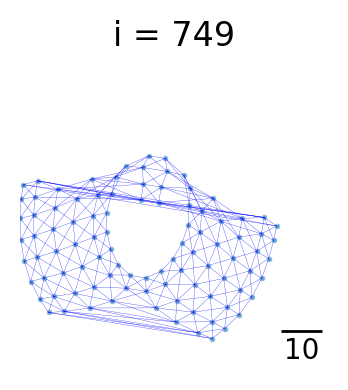

In [157]:
get_animation('can_96_A', initialize='random')

intermediates\can_96_A_random_annealed_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates
intermediates\can_96_A_random_annealed_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates\0.npy


C:\Users\alica\AppData\Local\Temp\ipykernel_1272\3106247384.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


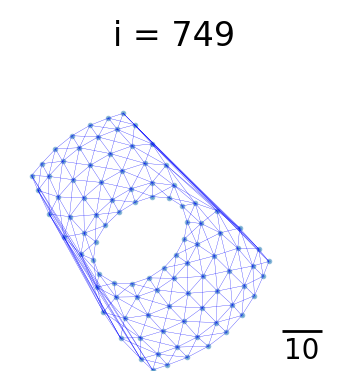

In [158]:
get_animation('can_96_A', initialize='random', method='annealed')

intermediates\can_96_A_spectral_standard_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates


C:\Users\alica\AppData\Local\Temp\ipykernel_1272\3106247384.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


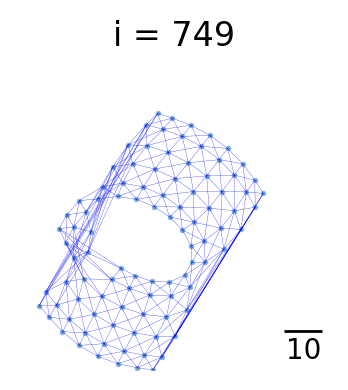

In [159]:
get_animation('can_96_A', initialize='spectral')

intermediates\can_96_A_spectral_annealed_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates
intermediates\can_96_A_spectral_annealed_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates\0.npy


C:\Users\alica\AppData\Local\Temp\ipykernel_1272\3106247384.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


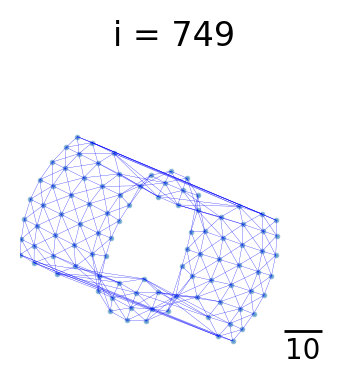

In [160]:
get_animation('can_96_A', initialize='spectral', method='annealed')

intermediates\dwt_1005_A_random_standard_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates


C:\Users\alica\AppData\Local\Temp\ipykernel_1272\3106247384.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


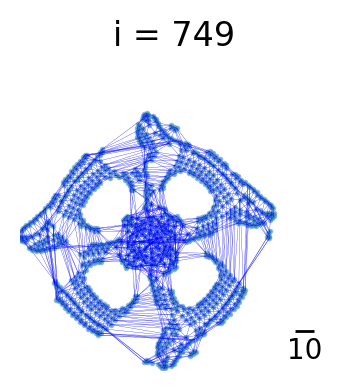

In [161]:
get_animation('dwt_1005_A', initialize='random')

intermediates\dwt_1005_A_random_annealed_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates
intermediates\dwt_1005_A_random_annealed_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates\0.npy


C:\Users\alica\AppData\Local\Temp\ipykernel_1272\3106247384.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


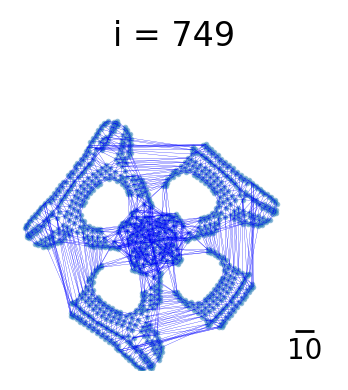

In [162]:
get_animation('dwt_1005_A', initialize='random', method='annealed')

intermediates\dwt_1005_A_spectral_standard_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates


C:\Users\alica\AppData\Local\Temp\ipykernel_1272\3106247384.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


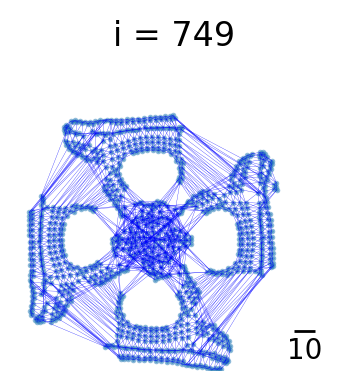

In [163]:
get_animation('dwt_1005_A', initialize='spectral')

intermediates\dwt_1005_A_spectral_annealed_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates
intermediates\dwt_1005_A_spectral_annealed_niter1-250_niter2-500_niterae-125_exag1-12_exag2-1_dof-1_False-noise_intermediates\0.npy


C:\Users\alica\AppData\Local\Temp\ipykernel_1272\3106247384.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


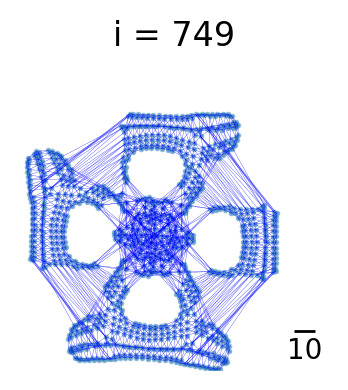

In [164]:
get_animation('dwt_1005_A', initialize='spectral', method='annealed')

In [165]:
def plot_initialization_True(I, file_name, initialize, matrix, save=True, colormap=False, fig = None, ax = None):
    """
    Plot the initialization of the graph.

    input:
    I: np.array, shape (n,2), coordinates of the nodes
    file_name: str, name of the file
    initialize: str, initialization of the graph
    matrix: np.array, shape (n,n), adjacency matrix of the graph
    save: bool, save the plot or not
    colormap: bool, color the edges by distance or not
    fig: plt.figure, figure to plot on
    ax: plt.axis, axis to plot on

    returns nothing
    """
    # create figure if nothing is given
    if (fig == None) or (ax == None):
        fig, ax = plt.subplots()

    plt.axis('off')    
    
    # create graph
    graph = nx.from_numpy_matrix(matrix)
    # remove self-loops around node
    graph.remove_edges_from(nx.selfloop_edges(graph))

    keys = graph.nodes
    
    # when colormap wanted
    if colormap == True:
        
        # compute distances  # You can attach any attributes you want when adding the edge
        distances = {}
        for start, end in graph.edges:
            distances[(start,end)] = np.sqrt((I[start,0]-I[end,0])**2 + (I[start,1]-I[end,1])**2)
        
        # draw edges, coloring by distances
        nx.draw_networkx_edges(graph, dict(zip(keys, zip(*[I[:,0], I[:,1]]))), width=0.1, ax=ax, edge_color=distances.values(), edge_cmap=plt.cm.autumn)
        cb = fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(distances.values()), vmax=max(distances.values())), cmap='autumn'),orientation="vertical", ticks =[min(distances.values()),max(distances.values())], ax=ax)
        cb.set_ticklabels(['short', 'long'])
        
    # when no colormap wanted
    elif colormap == False:
        
        # draw edges
        nx.draw_networkx_edges(graph, dict(zip(keys, zip(*[I[:,0], I[:,1]]))), width=0.1, ax=ax)
    
    else:
        ('Error. Colormap can either be True or False. plot_initialization_True function.')
    
    print(f'initialization = {initialize}, data = {file_name}')
    
    # save figure
    if save == True:
        fig.savefig(f'./plots/{initialize}/{file_name}_{initialize}_initialization.png')

    return


In [166]:
def tsne_graph_layout(file_name, title_str=None, colormap=False, save=False, plot_initialization=False, path=None, title=True, fig = None, ax = None):
    """
    Function to plot the graph layout of the t-SNE results.

    input:
    file_name: str, name of the file containing the t-SNE results
    title_str: str, title of the plot, if None, no title is shown
    colormap: bool, if True, edges are colored by distance
    save: bool, if True, the plot is saved
    plot_initialization: bool, if True, the initialization is plotted
    path: str, path to the file, if None, the file is in the same directory
    title: bool, if True, the title is shown
    fig: matplotlib figure, if None, a new figure is created
    ax: matplotlib axis, if None, a new axis is created

    returns nothing
    """
    # create figure and axis if not given
    if (fig == None) or (ax == None):
        fig, ax = plt.subplots()

    # load t-SNE results
    if path is not None:
        tsne = np.loadtxt(f'tsne_results/{path}/{file_name}.txt')
    else:
        tsne = np.loadtxt(f'tsne_results/{file_name}.txt')
    
    liste=file_name.split("_")
    
    # obtain parameters from filename
    matrix_file = f'{liste[0]}_{liste[1]}_{liste[2]}'
    initialize=liste[3]
    method = liste[4]
    exag1 = liste[5].split('-')[1]
    exag2 = liste[6].split('-')[1]
    n_iter1 = liste[8].split('-')[1]
    n_iter2 = liste[10].split('-')[1]
    n_iter_ae = liste[13].split('-')[1]
    dof = 1
    if (liste[-2] == 'dof'):
        dof = liste[-1]
    if (liste[-3] == 'dof'):
        dof = liste[-2]
    noise=False
    if liste[-1].split('-')[0]=='noise':
        noise = liste[-1].split('-')[1]
    print(f'noise={noise}')
    
    # load adjacency matrix
    matrix = sp.sparse.load_npz('./graph_data/'+matrix_file+'.npz')
    
    # load initialization
    if path is not None:
        I =  np.loadtxt(f'./tsne_results/{path}/{file_name}_initialization.txt')
    else:
        I =  np.loadtxt(f'./tsne_results/{file_name}_initialization.txt')

    # define graph
    graph = nx.from_numpy_matrix(matrix)
    # remove self loop around nodes
    graph.remove_edges_from(nx.selfloop_edges(graph))

    keys = graph.nodes
    
    # when colormap wanted
    if colormap == True:
        # compute distances  # You can attach any attributes you want when adding the edge  #nx.set_edge_attributes(graph, distances, name='eucledean_length')
        distances = {}
        for start, end in graph.edges:
            distances[(start,end)] = np.sqrt((tsne[start,0]-tsne[end,0])**2 + (tsne[start,1]-tsne[end,1])**2)
        # draw edges colored by distance
        nx.draw_networkx_edges(graph, dict(zip(keys, zip(*[tsne[:,0], tsne[:,1]]))), ax = ax, width=0.1, edge_color=distances.values(), edge_cmap=plt.cm.autumn).set_rasterized(True)
        cb = fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(distances.values()), vmax=max(distances.values())), cmap='autumn'),orientation="vertical", ticks =[min(distances.values()),max(distances.values())], ax=ax)
        cb.set_ticklabels(['short', 'long'])
        
    # if colormap not wanted
    elif colormap == False:
        # draw edges
        nx.draw_networkx_edges(graph, dict(zip(keys, zip(*[tsne[:,0], tsne[:,1]]))), ax=ax, width=0.1).set_rasterized(True)
        
    else:
        ('Error. Colormap can either be True or False in tsne_graph_layout function.')

    plt.axis('off')    

    # create directory if not existent
    os.makedirs(f'plots/{initialize}', exist_ok=True) if path == None else os.makedirs(f'plots/{initialize}/{path}', exist_ok=True)
    
    # methods
    if method == 'standard':
        if title == True:
            ax.set_title(title_str, loc='left')
        else:
            print(f'initialization = {initialize}, method = {method}, data = {matrix_file}\n n_iter1={n_iter1}, early exaggeration={exag1}\n late/no_exaggeration={exag2}, n_iter2={n_iter2}, dof={dof}')
        # save figure
        if save == True:
            if path is not None:
                fig.savefig(f'./plots/{initialize}/{path}/{matrix_file}_{method}_{initialize}_{n_iter1}_{n_iter2}_{exag1}_{exag2}_dof-{dof}_{noise}-noise_graph.png',bbox_inches='tight')
                print(f'./plots/{initialize}/{path}/{matrix_file}_{method}_{initialize}_{n_iter1}_{n_iter2}_{exag1}_{exag2}_dof-{dof}_{noise}-noise_graph.png')
            else:
                fig.savefig(f'./plots/{initialize}/{matrix_file}_{method}_{initialize}_{n_iter1}_{n_iter2}_{exag1}_{exag2}_dof-{dof}_{noise}-noise_graph.png',bbox_inches='tight')
            
    elif method == 'annealed':
        if title == True:
            fig.title(f'initialization = {initialize}, method = {method}, data = {matrix_file}\n n_iter1={n_iter_ae}, early exaggeration={exag1}\n late/no_exaggeration={exag2}, n_iter2={n_iter2}') 
        else:
            print(f'initialization = {initialize}, method = {method}, data = {matrix_file}\n n_iter1={n_iter_ae}, early exaggeration={exag1}\n late/no_exaggeration={exag2}, n_iter2={n_iter2}') 
        # save figure
        if save == True:
            if path is not None:
                fig.savefig(f'./plots/{initialize}/{path}/{matrix_file}_{method}_{initialize}_{n_iter_ae}_{n_iter2}_{exag1}_{exag2}_dof-{dof}_{noise}-noise_graph.png', bbox_inches='tight')
            else:
                fig.savefig(f'./plots/{initialize}/{matrix_file}_{method}_{initialize}_{n_iter_ae}_{n_iter2}_{exag1}_{exag2}_dof-{dof}_{noise}-noise_graph.png', bbox_inches='tight')
            
    else: 
        print('Method not implemented in tsne_graph_layout function.')
        
    # plot initialization
    if plot_initialization == True:
        plot_initialization_True(I, matrix_file, initialize, matrix, save=save, colormap=True)       

    return

noise=False
initialization = random, method = standard, data = can_96_A
 n_iter1=250, early exaggeration=12
 late/no_exaggeration=1, n_iter2=500, dof=1
initialization = random, data = can_96_A


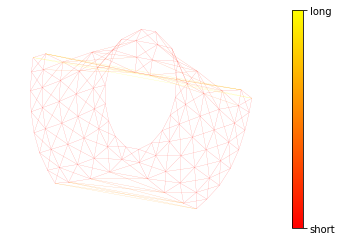

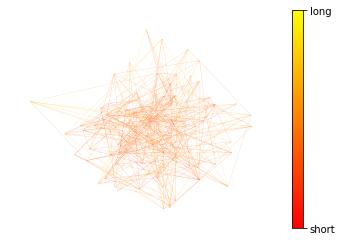

In [167]:
tsne_graph_layout('can_96_A_random_standard_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, plot_initialization=True, title=False)

noise=False
initialization = random, method = annealed, data = can_96_A
 n_iter1=125, early exaggeration=12
 late/no_exaggeration=1, n_iter2=500
initialization = random, data = can_96_A


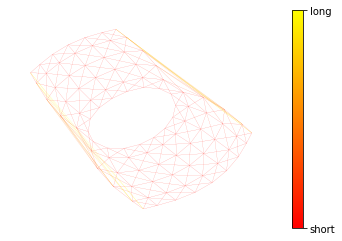

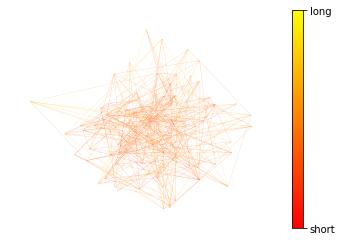

In [168]:
tsne_graph_layout('can_96_A_random_annealed_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, plot_initialization=True, title=False)

noise=False
initialization = spectral, method = standard, data = can_96_A
 n_iter1=250, early exaggeration=12
 late/no_exaggeration=1, n_iter2=500, dof=1
initialization = spectral, data = can_96_A


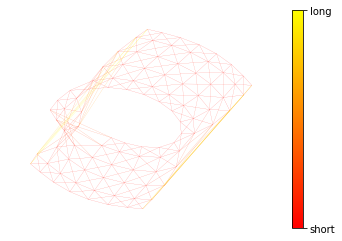

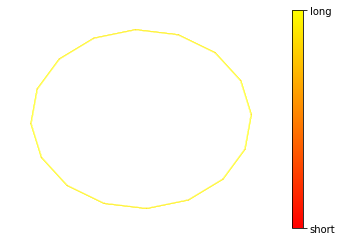

In [169]:
tsne_graph_layout('can_96_A_spectral_standard_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, plot_initialization=True, title=False)

noise=False
initialization = spectral, method = annealed, data = can_96_A
 n_iter1=125, early exaggeration=12
 late/no_exaggeration=1, n_iter2=500
initialization = spectral, data = can_96_A


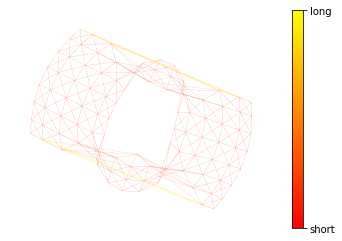

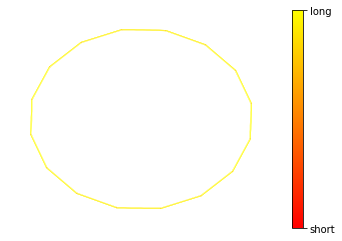

In [170]:
tsne_graph_layout('can_96_A_spectral_annealed_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, plot_initialization=True, title=False)

noise=False
initialization = random, method = standard, data = dwt_1005_A
 n_iter1=250, early exaggeration=12
 late/no_exaggeration=1, n_iter2=500, dof=1
initialization = random, data = dwt_1005_A


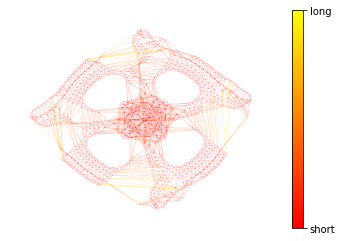

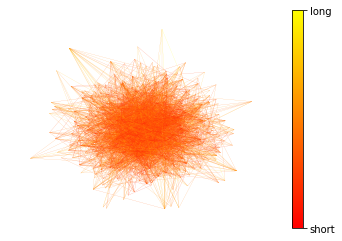

In [171]:
tsne_graph_layout('dwt_1005_A_random_standard_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, plot_initialization=True, title=False)

noise=False
initialization = random, method = annealed, data = dwt_1005_A
 n_iter1=125, early exaggeration=12
 late/no_exaggeration=1, n_iter2=500
initialization = random, data = dwt_1005_A


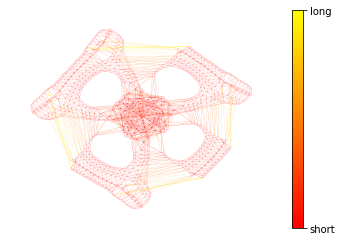

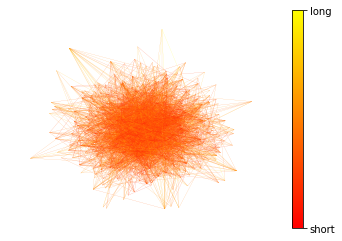

In [172]:
tsne_graph_layout('dwt_1005_A_random_annealed_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, plot_initialization=True, title=False)

noise=False
initialization = spectral, method = standard, data = dwt_1005_A
 n_iter1=250, early exaggeration=12
 late/no_exaggeration=1, n_iter2=500, dof=1
initialization = spectral, data = dwt_1005_A


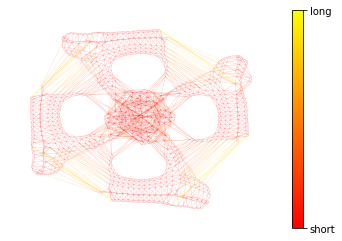

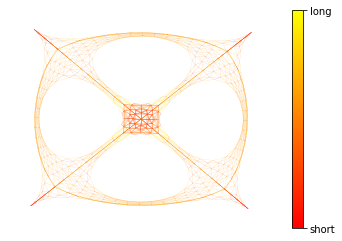

In [173]:
tsne_graph_layout('dwt_1005_A_spectral_standard_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, plot_initialization=True, title=False)

noise=False
initialization = spectral, method = annealed, data = dwt_1005_A
 n_iter1=125, early exaggeration=12
 late/no_exaggeration=1, n_iter2=500
initialization = spectral, data = dwt_1005_A


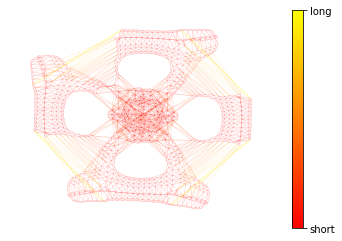

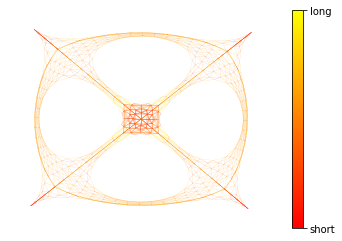

In [174]:
tsne_graph_layout('dwt_1005_A_spectral_annealed_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, plot_initialization=True, title=False)

# Testing Different Late Exaggerations

In [175]:
exags=[1,4,12]

In [176]:
for e in exags:
    result_tsne = get_tsne('can_96_A', initialize='spectral', exag2=e)
    save_tsne_tuple(result_tsne, path='exag2')

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=8.00 for 250 iterations...
Iteration   50, KL divergence 2.3620, 50 iterations in 0.0572 sec
Iteration  100, KL divergence 2.4193, 50 iterations in 0.0577 sec
Iteration  150, KL divergence 2.4196, 50 iterations in 0.0613 sec
Iteration  200, KL divergence 2.4195, 50 iterations in 0.0734 sec
Iteration  250, KL divergence 2.4195, 50 iterations in 0.0646 sec
   --> Time elapsed: 0.31 seconds
===> Running optimization with exaggeration=1.00, lr=96.00 for 500 iterations...
Iteration   50, KL divergence 1.1293, 50 iterations in 0.0637 sec
Iteration  100, KL divergence 1.1644, 50 iterations in 0.0645 sec
Iteration  150, KL divergence 1.0212, 50 iterations in 0.0664 sec
Iteration  200, KL divergence 0.9789, 50 iterations in 0.0662 sec
Iteration  250, KL divergence 0.9321, 50 iterations in 0.0648 sec
Iteration  300, KL divergence 0.9245, 50 iterations in 0.0665 sec
Iteration  350, KL divergence 0.9204, 5

1
noise=False
./plots/spectral/exag2/can_96_A_standard_spectral_250_500_12_1_dof-1_False-noise_graph.png
4
noise=False
./plots/spectral/exag2/can_96_A_standard_spectral_250_500_12_4_dof-1_False-noise_graph.png
12
noise=False
./plots/spectral/exag2/can_96_A_standard_spectral_250_500_12_12_dof-1_False-noise_graph.png


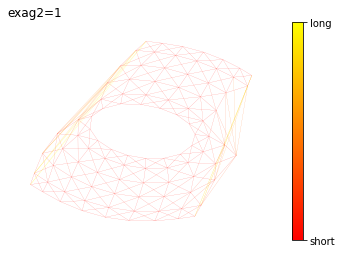

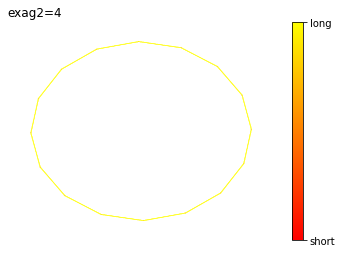

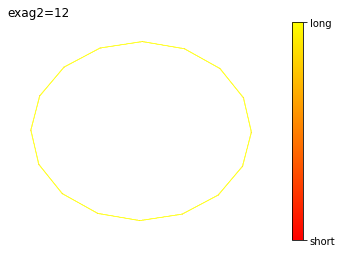

In [177]:
for e in exags:
    print(e)
    tsne_graph_layout(f'can_96_A_spectral_standard_exag1-12_exag2-{e}_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, path='exag2', plot_initialization = False, title=True, title_str=f'exag2={e}')


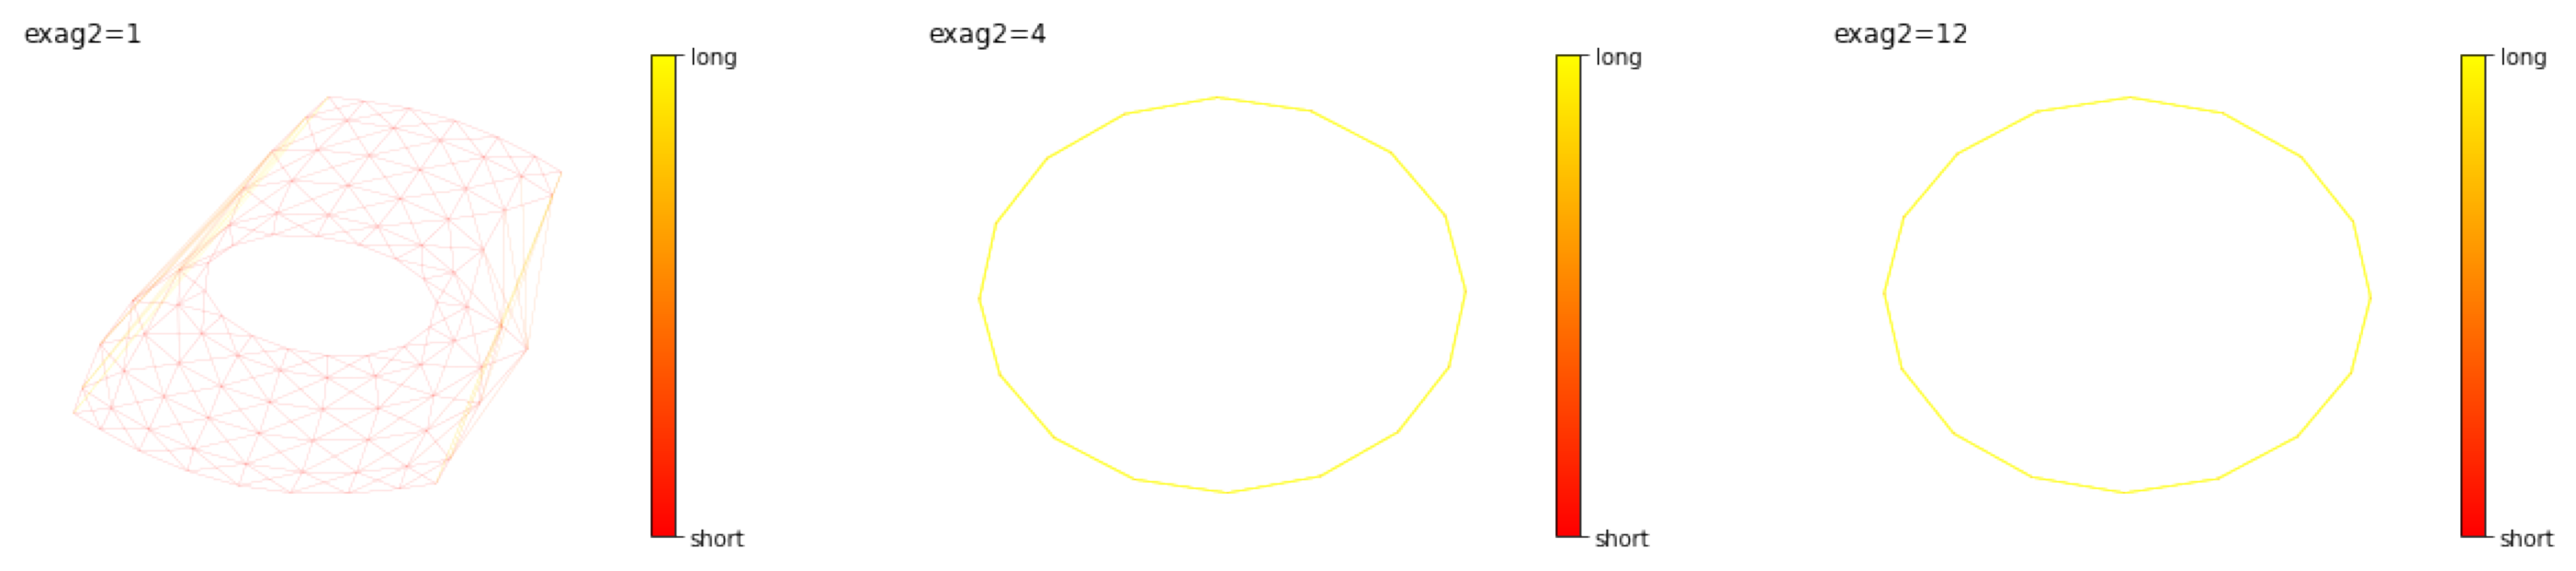

In [179]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50,15))
axes = [ax1, ax2, ax3] 

for i,ax  in enumerate(axes):
    fig = mpimg.imread(f'./plots/spectral/exag2/can_96_A_standard_spectral_250_500_12_{exags[i]}_dof-1_False-noise_graph.png')
    ax.imshow(fig)
    ax.axis('off')
os.makedirs('plots/exag2', exist_ok=True)
plt.savefig(f'./plots/exag2/dofs_can_96_spectral.png')
plt.show()

In [180]:
for e in exags:
    result_tsne = get_tsne('dwt_1005_A', initialize='spectral', exag2=e)
    save_tsne_tuple(result_tsne, path='exag2')

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=83.75 for 250 iterations...
Iteration   50, KL divergence 3.2307, 50 iterations in 0.1294 sec
Iteration  100, KL divergence 3.2624, 50 iterations in 0.1437 sec
Iteration  150, KL divergence 3.2770, 50 iterations in 0.1616 sec
Iteration  200, KL divergence 3.2768, 50 iterations in 0.1522 sec
Iteration  250, KL divergence 3.2768, 50 iterations in 0.1406 sec
   --> Time elapsed: 0.73 seconds
===> Running optimization with exaggeration=1.00, lr=1005.00 for 500 iterations...
Iteration   50, KL divergence 1.4551, 50 iterations in 0.1451 sec
Iteration  100, KL divergence 1.3563, 50 iterations in 0.1397 sec
Iteration  150, KL divergence 1.3249, 50 iterations in 0.1548 sec
Iteration  200, KL divergence 1.3095, 50 iterations in 0.1490 sec
Iteration  250, KL divergence 1.3004, 50 iterations in 0.1529 sec
Iteration  300, KL divergence 1.2935, 50 iterations in 0.1423 sec
Iteration  350, KL divergence 1.2885

1
noise=False
./plots/spectral/exag2/dwt_1005_A_standard_spectral_250_500_12_1_dof-1_False-noise_graph.png
4
noise=False
./plots/spectral/exag2/dwt_1005_A_standard_spectral_250_500_12_4_dof-1_False-noise_graph.png
12
noise=False
./plots/spectral/exag2/dwt_1005_A_standard_spectral_250_500_12_12_dof-1_False-noise_graph.png


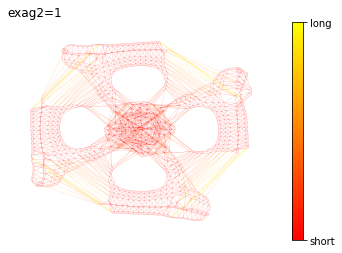

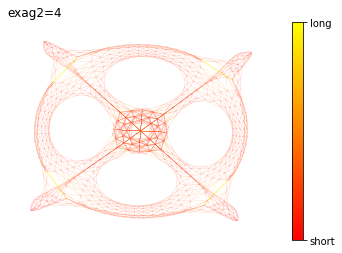

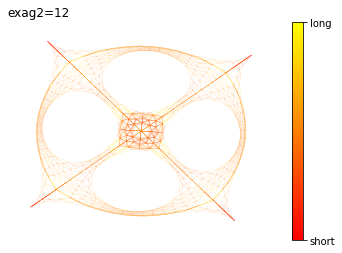

In [181]:
for e in exags:
    print(e)
    tsne_graph_layout(f'dwt_1005_A_spectral_standard_exag1-12_exag2-{e}_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_1_noise-False', colormap=True, save=True, path='exag2', plot_initialization = False, title=True, title_str=f'exag2={e}')


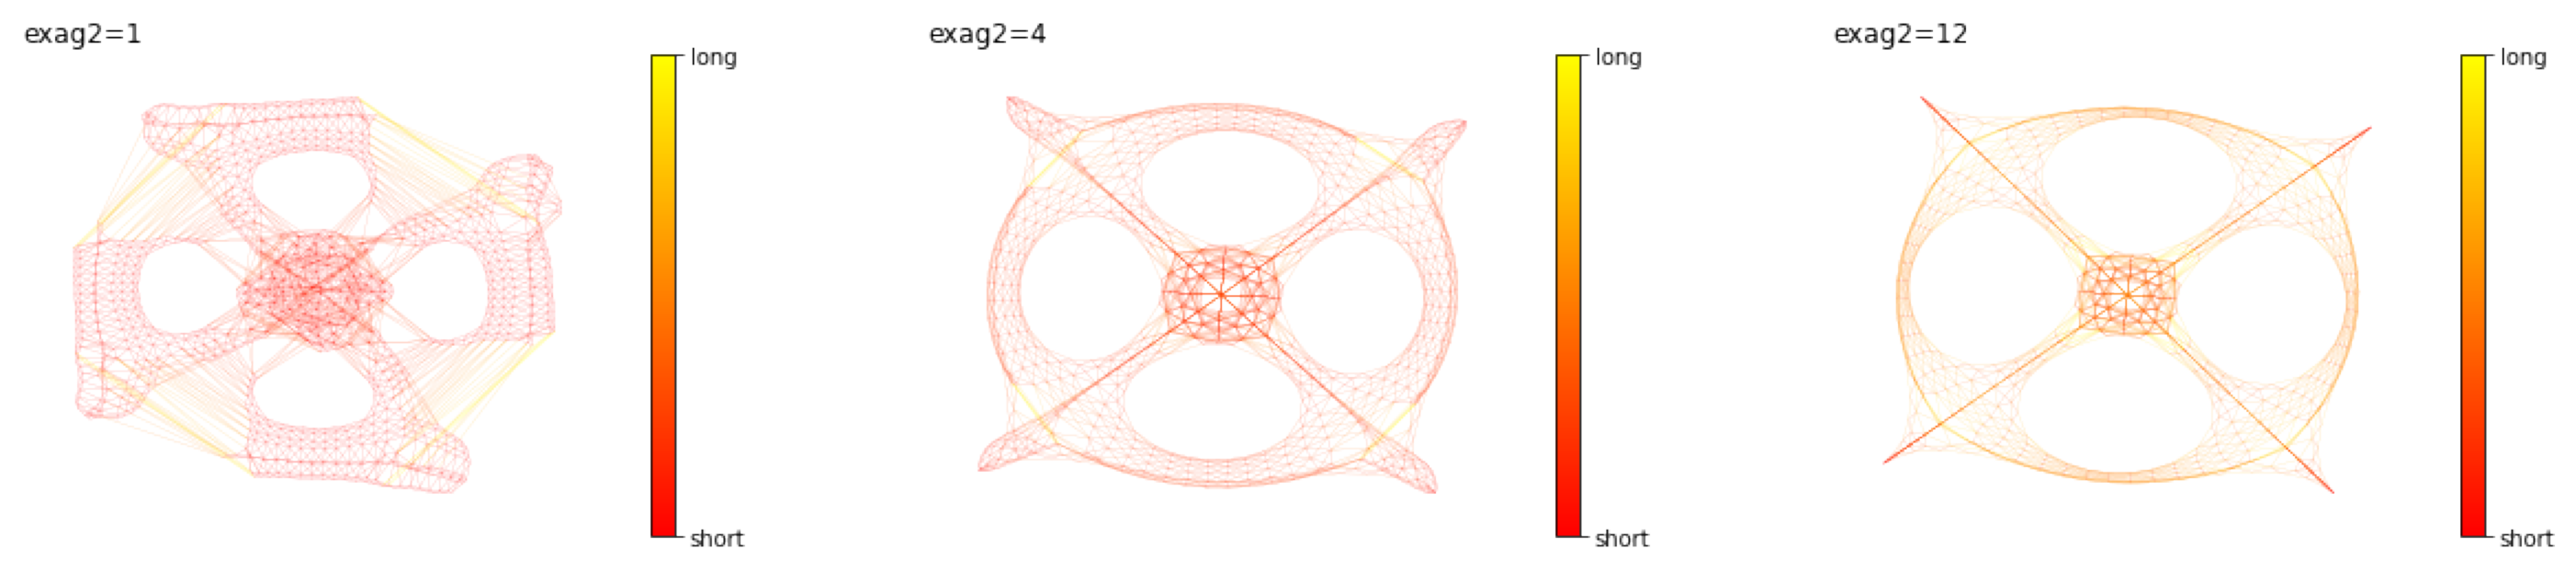

In [182]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50,15))
axes = [ax1, ax2, ax3] 

for i,ax  in enumerate(axes):
    fig = mpimg.imread(f'./plots/spectral/exag2/dwt_1005_A_standard_spectral_250_500_12_{exags[i]}_dof-1_False-noise_graph.png')
    ax.imshow(fig)
    ax.axis('off')
os.makedirs('plots/exag2', exist_ok=True)
plt.savefig(f'./plots/exag2/dofs_dwt_1005_spectral.png')
plt.show()

# Testing Different Degrees of Freedom

In [183]:
dofs=[0.5,1,10,100]

In [184]:
for d in dofs:
    result_tsne = get_tsne('can_96_A', initialize='spectral', dof=d)
    save_tsne_tuple(result_tsne, path='dofs')

CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=8.00 for 250 iterations...
Iteration   50, KL divergence 2.4720, 50 iterations in 0.1671 sec
Iteration  100, KL divergence 2.5075, 50 iterations in 0.0773 sec
Iteration  150, KL divergence 2.5077, 50 iterations in 0.0903 sec
Iteration  200, KL divergence 2.5077, 50 iterations in 0.0764 sec
Iteration  250, KL divergence 2.5077, 50 iterations in 0.0798 sec
   --> Time elapsed: 0.49 seconds
===> Running optimization with exaggeration=1.00, lr=96.00 for 500 iterations...
Iteration   50, KL divergence 2.7363, 50 iterations in 0.0745 sec
Iteration  100, KL divergence 2.7145, 50 iterations in 0.0807 sec
Iteration  150, KL divergence 2.7627, 50 iterations in 0.0780 sec
Iteration  200, KL divergence 2.8363, 50 iterations in 0.0808 sec
Iteration  250, KL divergence 2.9086, 50 iterations in 0.0894 sec
Iteration  300, KL divergence 2.9617, 50 iterations in 0.0827 sec
Iteration  350, KL divergence 2.9957, 5

In [185]:
for d in dofs:
    result_tsne = get_tsne('dwt_1005_A', initialize='spectral', dof=d)
    save_tsne_tuple(result_tsne, path='dofs')


CPU times: total: 0 ns
Wall time: 0 ns
===> Running optimization with exaggeration=12.00, lr=83.75 for 250 iterations...
Iteration   50, KL divergence 3.9163, 50 iterations in 0.3147 sec
Iteration  100, KL divergence 3.9278, 50 iterations in 0.2907 sec
Iteration  150, KL divergence 3.9356, 50 iterations in 0.3083 sec
Iteration  200, KL divergence 3.9357, 50 iterations in 0.2924 sec
Iteration  250, KL divergence 3.9357, 50 iterations in 0.2874 sec
   --> Time elapsed: 1.49 seconds
===> Running optimization with exaggeration=1.00, lr=1005.00 for 500 iterations...
Iteration   50, KL divergence 3.1614, 50 iterations in 0.2623 sec
Iteration  100, KL divergence 3.1132, 50 iterations in 0.4855 sec
Iteration  150, KL divergence 3.0917, 50 iterations in 0.2792 sec
Iteration  200, KL divergence 3.0834, 50 iterations in 0.2547 sec
Iteration  250, KL divergence 3.0804, 50 iterations in 0.2878 sec
Iteration  300, KL divergence 3.0787, 50 iterations in 0.2292 sec
Iteration  350, KL divergence 3.0791

0.5
noise=False
./plots/spectral/dofs/can_96_A_standard_spectral_250_500_12_1_dof-0.5_False-noise_graph.png
1
noise=False
./plots/spectral/dofs/can_96_A_standard_spectral_250_500_12_1_dof-1_False-noise_graph.png
10
noise=False
./plots/spectral/dofs/can_96_A_standard_spectral_250_500_12_1_dof-10_False-noise_graph.png
100
noise=False
./plots/spectral/dofs/can_96_A_standard_spectral_250_500_12_1_dof-100_False-noise_graph.png


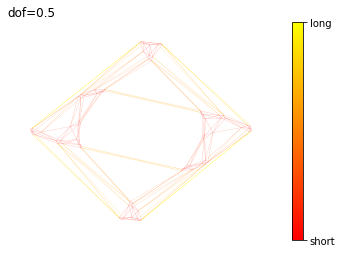

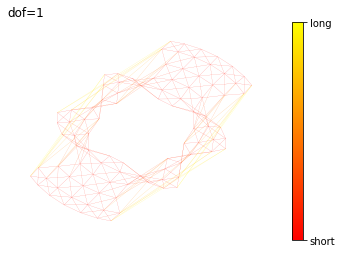

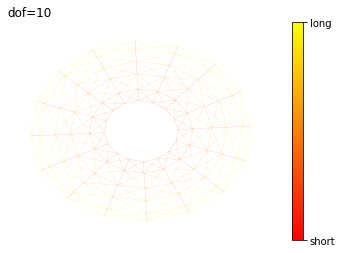

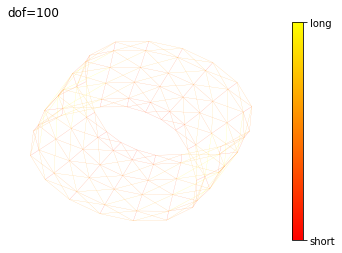

In [186]:
for d in dofs:
    print(d)
    tsne_graph_layout(f'can_96_A_spectral_standard_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_{d}_noise-False', colormap=True, save=True, path='dofs', plot_initialization = False, title=True, title_str=f'dof={d}')



0.5
noise=False
./plots/spectral/dofs/dwt_1005_A_standard_spectral_250_500_12_1_dof-0.5_False-noise_graph.png
1
noise=False
./plots/spectral/dofs/dwt_1005_A_standard_spectral_250_500_12_1_dof-1_False-noise_graph.png
10
noise=False
./plots/spectral/dofs/dwt_1005_A_standard_spectral_250_500_12_1_dof-10_False-noise_graph.png
100
noise=False
./plots/spectral/dofs/dwt_1005_A_standard_spectral_250_500_12_1_dof-100_False-noise_graph.png


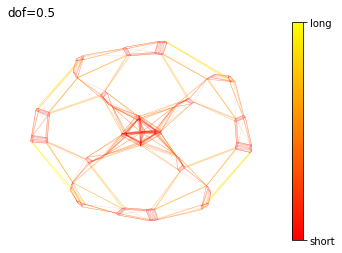

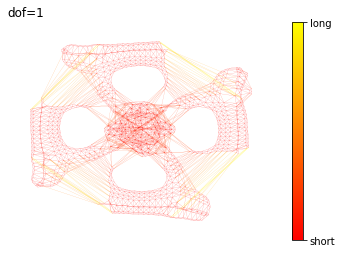

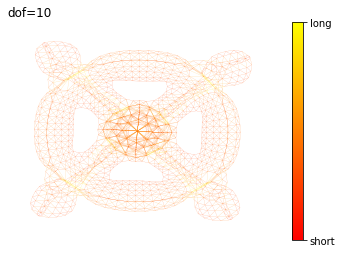

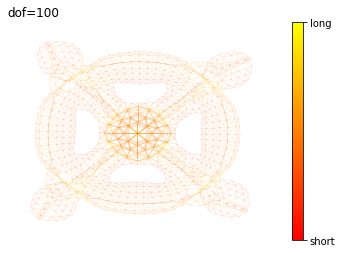

In [187]:
for d in dofs:
    print(d)
    tsne_graph_layout(f'dwt_1005_A_spectral_standard_exag1-12_exag2-1_n_iter1-250_n_iter2-500_n_iter_ae-125_dof_{d}_noise-False', colormap=True, save=True, path='dofs', plot_initialization = False, title=True, title_str=f'dof={d}')


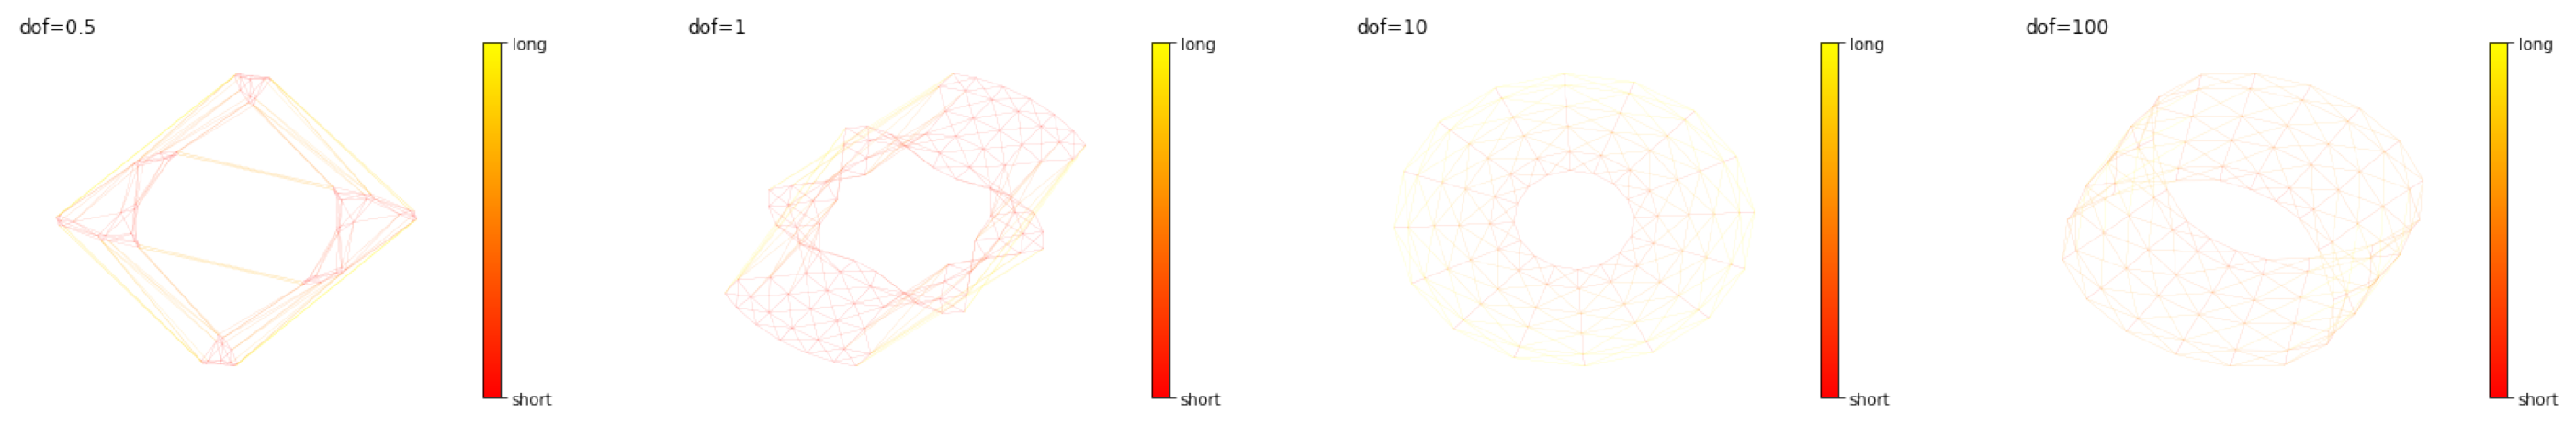

In [188]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(50,15))
axes = [ax1, ax2, ax3, ax4] 

for i,ax  in enumerate(axes):
    fig = mpimg.imread(f'./plots/spectral/dofs/can_96_A_standard_spectral_250_500_12_1_dof-{dofs[i]}_False-noise_graph.png')
    ax.imshow(fig)
    ax.axis('off')
os.makedirs('plots/dof', exist_ok=True)
plt.savefig(f'./plots/dof/dofs_can_96_spectral.png')
plt.show()

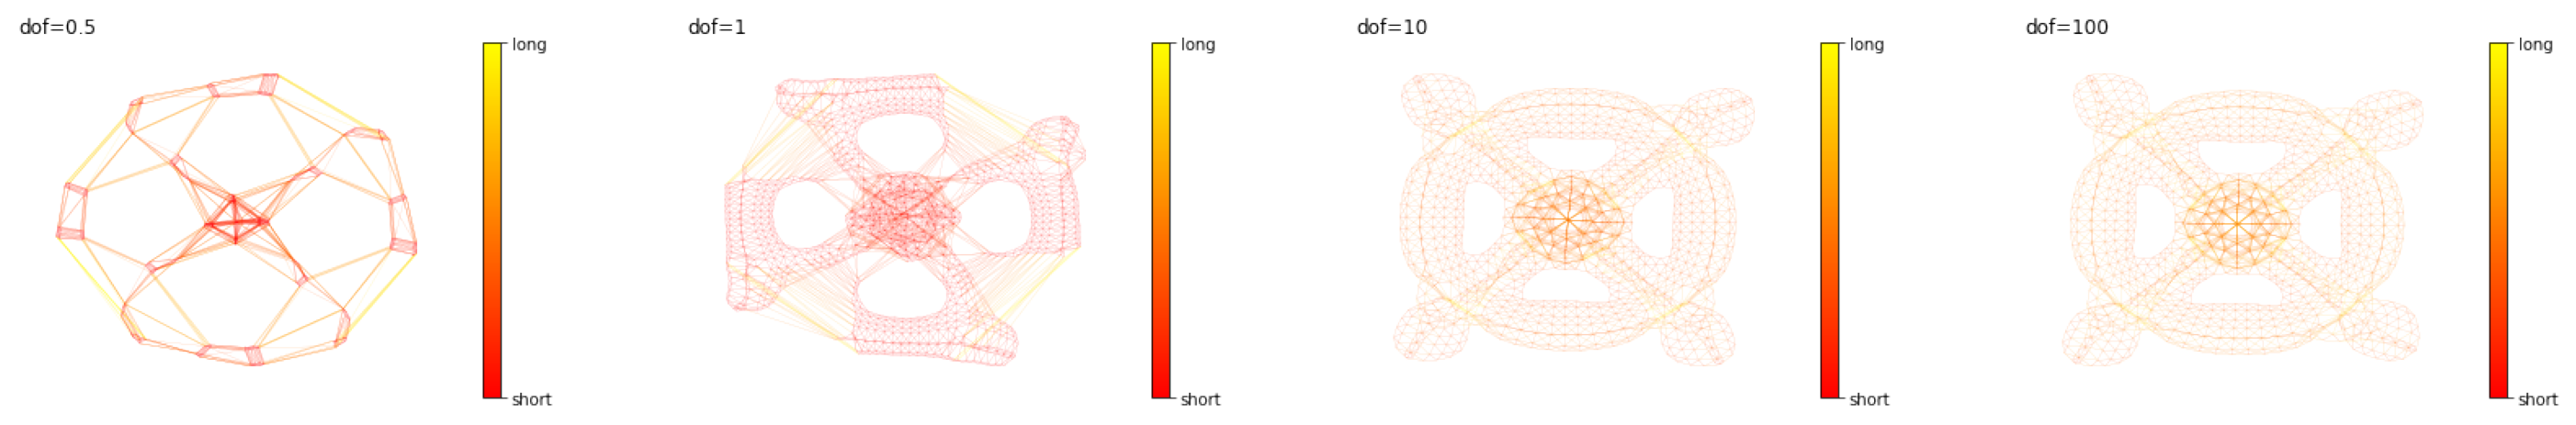

In [189]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(50,15))
axes = [ax1, ax2, ax3, ax4] 

for i,ax  in enumerate(axes):
    fig = mpimg.imread(f'./plots/spectral/dofs/dwt_1005_A_standard_spectral_250_500_12_1_dof-{dofs[i]}_False-noise_graph.png')
    ax.imshow(fig)
    ax.axis('off')
os.makedirs('plots/dof', exist_ok=True)
plt.savefig(f'./plots/dof/dofs_dwt_1005_spectral.png')
plt.show()

In [190]:
# Compute kNN recall for all neighbours for different values of exag2 and dof

initializations = ['spectral']
graphs = ['can_96', 'dwt_1005']

for g in graphs:
    print(g)

    e = 1
    for d in dofs:
        k = kNN_recalls_allneighbours(g+'_A', d, e, initializations[0], path = 'dofs')
        print(f'dof = {d}, exag2 = {e}, kNN-recall: {k}')
        

    d = 1
    for e in exags:
        k = kNN_recalls_allneighbours(g+'_A', d, e, initializations[0], path = 'exag2')
        print(f'dof = {d}, exag2 = {e}, kNN-recall: {k}')

can_96
dof = 0.5, exag2 = 1, kNN-recall: 0.6766
dof = 1, exag2 = 1, kNN-recall: 0.8044
dof = 10, exag2 = 1, kNN-recall: 0.8318
dof = 100, exag2 = 1, kNN-recall: 0.7695
dof = 1, exag2 = 1, kNN-recall: 0.8805
dof = 1, exag2 = 4, kNN-recall: 0.3609
dof = 1, exag2 = 12, kNN-recall: 0.3583
dwt_1005
dof = 0.5, exag2 = 1, kNN-recall: 0.6677
dof = 1, exag2 = 1, kNN-recall: 0.8073
dof = 10, exag2 = 1, kNN-recall: 0.7321
dof = 100, exag2 = 1, kNN-recall: 0.718
dof = 1, exag2 = 1, kNN-recall: 0.8073
dof = 1, exag2 = 4, kNN-recall: 0.5615
dof = 1, exag2 = 12, kNN-recall: 0.4046
